In [1]:
import tensorflow as tf
import keras
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
from sklearn.model_selection import train_test_split
import re
import os
import time

from nn_helpers import get_labeled_images, side_by_side, one_hot_encode

print(tf.__version__)

Using TensorFlow backend.


1.3.0


In [2]:
X_train, X_test, y_train, y_test  = get_labeled_images('dataset/*.png')

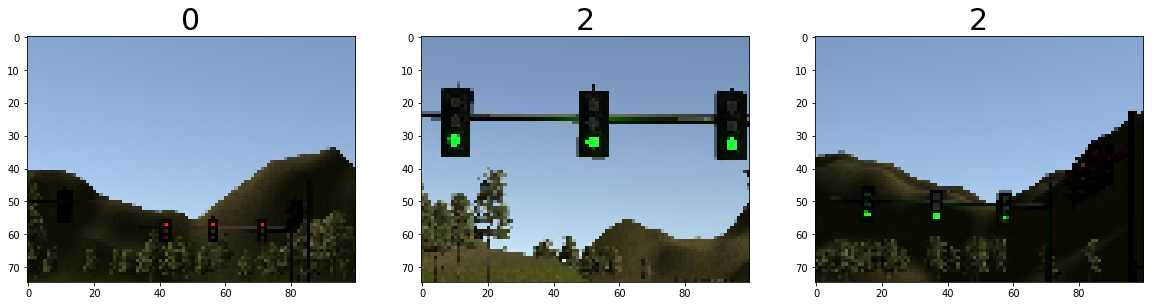

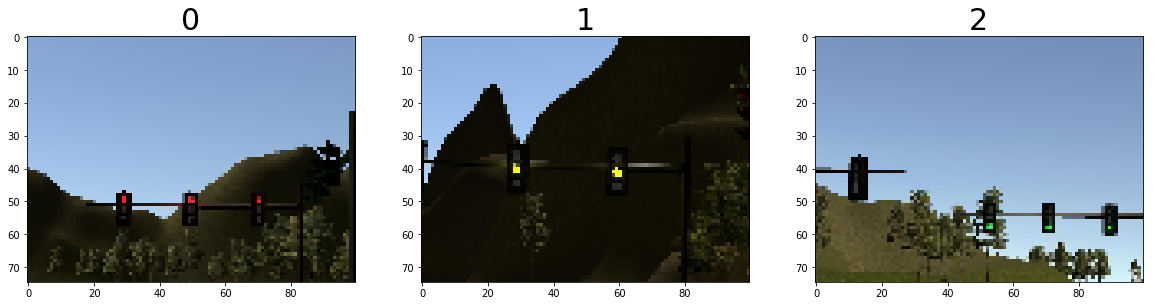

In [3]:
side_by_side(X_train[:3], y_train[:3])
side_by_side(X_train[103:106], y_train[103:106])

In [4]:
print("Num Training Images: {}, Num Test Images: {}".format(len(X_train), len(X_test)))
print("Image shape: {}".format(X_train[0].shape))
print(150*200*3)
print("Labels: {}".format(set(y_train)))
print("Training set distribution -- 0s: {}, 1s: {}, 2s: {}".format(y_train.count(0), y_train.count(1), y_train.count(2)))
print("Test set distribution -- 0s: {}, 1s: {}, 2s: {}".format(y_test.count(0), y_test.count(1), y_test.count(2)))

Num Training Images: 958, Num Test Images: 240
Image shape: (75, 100, 3)
90000
Labels: set([0, 1, 2])
Training set distribution -- 0s: 397, 1s: 148, 2s: 413
Test set distribution -- 0s: 104, 1s: 36, 2s: 100


In [5]:
one_hot_test = one_hot_encode(y_test)
one_hot_train = one_hot_encode(y_train)
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape, one_hot_train.shape)
print(X_test.shape, one_hot_test.shape)

((958, 75, 100, 3), (958, 3))
((240, 75, 100, 3), (240, 3))


In [6]:
checkpoint_path = "training_ckpts/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [7]:
def create_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(16, kernel_size=(3,3), strides=(1,1), padding="same", activation=tf.nn.relu, input_shape=(75,100,3,)),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding="same", activation=tf.nn.relu),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same", activation=tf.nn.relu),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(3, activation=tf.nn.softmax)
      ])
    
    model.compile(optimizer=keras.optimizers.Adam(), 
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])
    
    return model

In [33]:
K.set_learning_phase(1)
K.clear_session()
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 16)       448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 12, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 12, 64)         0         
__________

In [34]:
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1, period=10)
model.fit(X_train, one_hot_train, epochs=10, callbacks=[cp_callback])

Epoch 1/10
958/958 [==============================] - 3s - loss: 0.9737 - acc: 0.5167     
Epoch 2/10
958/958 [==============================] - 3s - loss: 0.7541 - acc: 0.6681     
Epoch 3/10
958/958 [==============================] - 3s - loss: 0.4945 - acc: 0.7985     
Epoch 4/10
958/958 [==============================] - 3s - loss: 0.3263 - acc: 0.8768     
Epoch 5/10
958/958 [==============================] - 3s - loss: 0.1428 - acc: 0.9572     
Epoch 6/10
958/958 [==============================] - 3s - loss: 0.0649 - acc: 0.9875     
Epoch 7/10
958/958 [==============================] - 3s - loss: 0.1233 - acc: 0.9635     
Epoch 8/10
958/958 [==============================] - 3s - loss: 0.0689 - acc: 0.9823     
Epoch 9/10
958/958 [==============================] - 3s - loss: 0.0284 - acc: 0.9958     
Epoch 10/10
958/958 [==============================] - 3s - loss: 0.0213 - acc: 0.9948     


In [35]:
loss, acc = model.evaluate(X_test, one_hot_test)
print("\nAccuracy: {}".format(acc))

224/240 [===========================>..] - ETA: 0s
Accuracy: 1.0


In [36]:
model.save('traffic_light_classifier.h5')